In [7]:
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/code_states/s4_project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import numpy as np
import pandas as pd
import pickle
import keras
import matplotlib.pyplot as plt

In [9]:
# checkpoint 불러오기 ( 저장된 파일 확인 )
with open(path + '/audio_df_01_spt.pickle', 'rb') as f:
    spt = pickle.load(f)
with open(path + '/audio_df_01_ins.pickle', 'rb') as f:
    ins = pickle.load(f)

In [10]:
print("spt, ins의 수", len(spt), len(ins))
print("ins의 종류 : ", len(set(ins)))

spt, ins의 수 19200 19200
ins의 종류 :  128


In [11]:
print(ins[0])

0


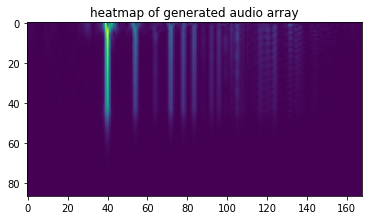

In [12]:
import librosa
plt.Figure(figsize=(12, 2)) 
plt.imshow(spt[0].T) 
plt.title("heatmap of generated audio array") 
plt.show()

#### Scaler : MinMaxScaler와 같은 방식

np.array형식이기 때문에 Scaler 적용 불가<br/>
Scaler는 DataFrame에 적용 가능<br/>

spt는 DataFrame에 그대로 넣을 수가 없었습니다.
list 형식이기 때문에 string 형식으로 타입 변환을 한 뒤 넣어야했습니다.<br/> 이 방식은 데이터를 꺼내올 때도 string to list 연산으로 바꿔줘야하기 때문에 np.array 형식으로 계산하기로 결정했습니다.

In [13]:
spt = np.array(spt)
ins = np.array(ins)

In [14]:
spt_max = np.max(spt)
spt_min = np.min(spt)
spt_max, spt_min

(13.270682392935731, 0.0)

In [16]:
# MinMaxScaler와 같은 방식으로 scaling.

spt_scaled = (spt - spt_min) / (spt_max - spt_min)

In [17]:
spt_scaled.min(), spt_scaled.max()

(0.0, 1.0)

라벨인코더는 안해도 될 것 같다.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(spt_scaled, ins, test_size=0.2, stratify=ins) # spt로 ins 추측
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train) # spt로 ins 추측

X_train.shape, X_val.shape, X_test.shape

((12288, 168, 87), (3072, 168, 87), (3840, 168, 87))

### Model 작성

In [19]:
from tensorflow.keras import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model

In [20]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

input_shape

(168, 87, 1)

In [21]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3,3), strides=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, kernel_size=(3,3), strides=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(129, activation="softmax"))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
# model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 168, 87, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 44, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 22, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 42, 22, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 5, 64)        0         
 2D)                                                    

In [24]:
from keras.models import load_model

class save(keras.callbacks.Callback):
 def __init__(self, model):
  self.count = 0
  self.model = model

 def on_epoch_end(self, bath, logs={}):
  self.count = self.count + 1
  if self.count % 10 == 0:
   model.save("mymodel_epoch_{}.h5".format(self.count))

In [25]:
s = save(model)
es = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/30
384/384 [==============================] - 122s 315ms/step - loss: 4.6893 - accuracy: 0.0168 - val_loss: 4.3219 - val_accuracy: 0.0407
Epoch 2/30
384/384 [==============================] - 121s 315ms/step - loss: 4.1197 - accuracy: 0.0576 - val_loss: 3.5860 - val_accuracy: 0.1533
Epoch 3/30
384/384 [==============================] - 124s 324ms/step - loss: 3.4813 - accuracy: 0.1299 - val_loss: 2.7638 - val_accuracy: 0.2926
Epoch 4/30
384/384 [==============================] - 125s 326ms/step - loss: 2.9327 - accuracy: 0.2207 - val_loss: 2.2855 - val_accuracy: 0.4043
Epoch 5/30
384/384 [==============================] - 122s 319ms/step - loss: 2.5352 - accuracy: 0.2865 - val_loss: 1.8444 - val_accuracy: 0.5052
Epoch 6/30
384/384 [==============================] - 122s 318ms/step - loss: 2.2176 - accuracy: 0.3500 - val_loss: 1.5086 - val_accuracy: 0.5954
Epoch 7/30
384/384 [==============================] - 121s 316ms/step - loss: 1.9715 - accuracy: 0.4155 - val_loss: 1.2552 -

In [26]:
result = model.evaluate(X_test, y_test, batch_size=64)
print('test loss, test acc:', result)

60/60 [==============================] - 10s 171ms/step - loss: 0.3317 - accuracy: 0.8961
test loss, test acc: [0.3316746950149536, 0.8960937261581421]


In [27]:
y_pred = model.predict(X_test)
len(X_test), len(y_pred), len(y_pred[0])

(3840, 3840, 129)

In [28]:
y_pred_index = []
for data in y_pred :
  y_pred_index.append(np.argmax(data))
len(y_pred_index)

3840

### 성능 평가

1. 정확도 ( Accuracy )
2. 오차 행렬 ( Confusion Matrix )
3. 정밀도 ( Precision )
4. 재현율 ( Recall )
5. F1-score : 불균형 여부 확인. 높을수록 좋다.acc와 비교 ( inbalanced한 데이터일 경우 차이가 크다 )
6. ROC : 임계값 확인
7. AUC : ROC 곡선 밑의 면적. 1에 가까울수록 좋다.


In [29]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score

print("accuracy_score : ",accuracy_score(y_test, y_pred_index))
print("recall_score : ",recall_score(y_test, y_pred_index, average='macro'))
print("precision_score : ",precision_score(y_test, y_pred_index, average='macro'))
print("f1_score : ",f1_score(y_test, y_pred_index, average='macro'))

accuracy_score :  0.89609375
recall_score :  0.8960937500000001
precision_score :  0.9199584196152848
f1_score :  0.8978475295072085


In [30]:
print(classification_report(y_test, y_pred_index))

              precision    recall  f1-score   support

           0       0.38      0.93      0.54        30
           1       0.46      0.20      0.28        30
           2       0.65      0.57      0.61        30
           3       1.00      0.77      0.87        30
           4       0.55      0.20      0.29        30
           5       0.93      0.93      0.93        30
           6       1.00      0.80      0.89        30
           7       1.00      0.93      0.97        30
           8       0.93      0.93      0.93        30
           9       0.91      1.00      0.95        30
          10       0.96      0.90      0.93        30
          11       0.91      1.00      0.95        30
          12       0.78      0.97      0.87        30
          13       1.00      1.00      1.00        30
          14       0.93      0.83      0.88        30
          15       1.00      0.93      0.97        30
          16       0.97      1.00      0.98        30
          17       0.91    

In [31]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

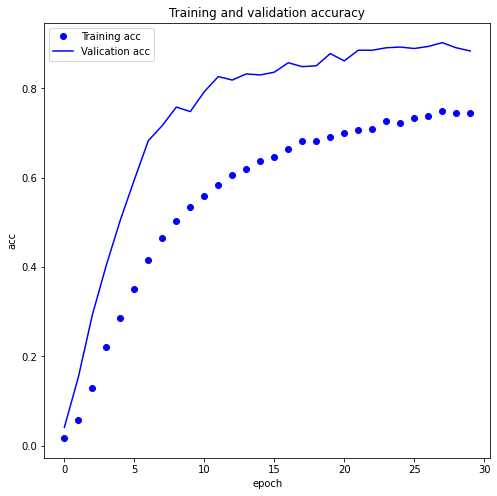

In [32]:
# 정확도
plt.figure(figsize=(8,8))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Valication acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

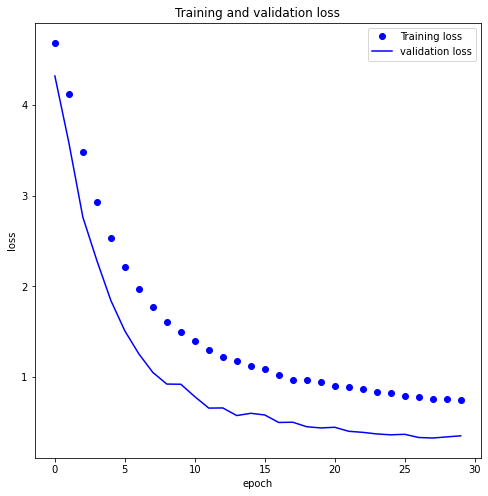

In [33]:
# loss
plt.figure(figsize=(8,8))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

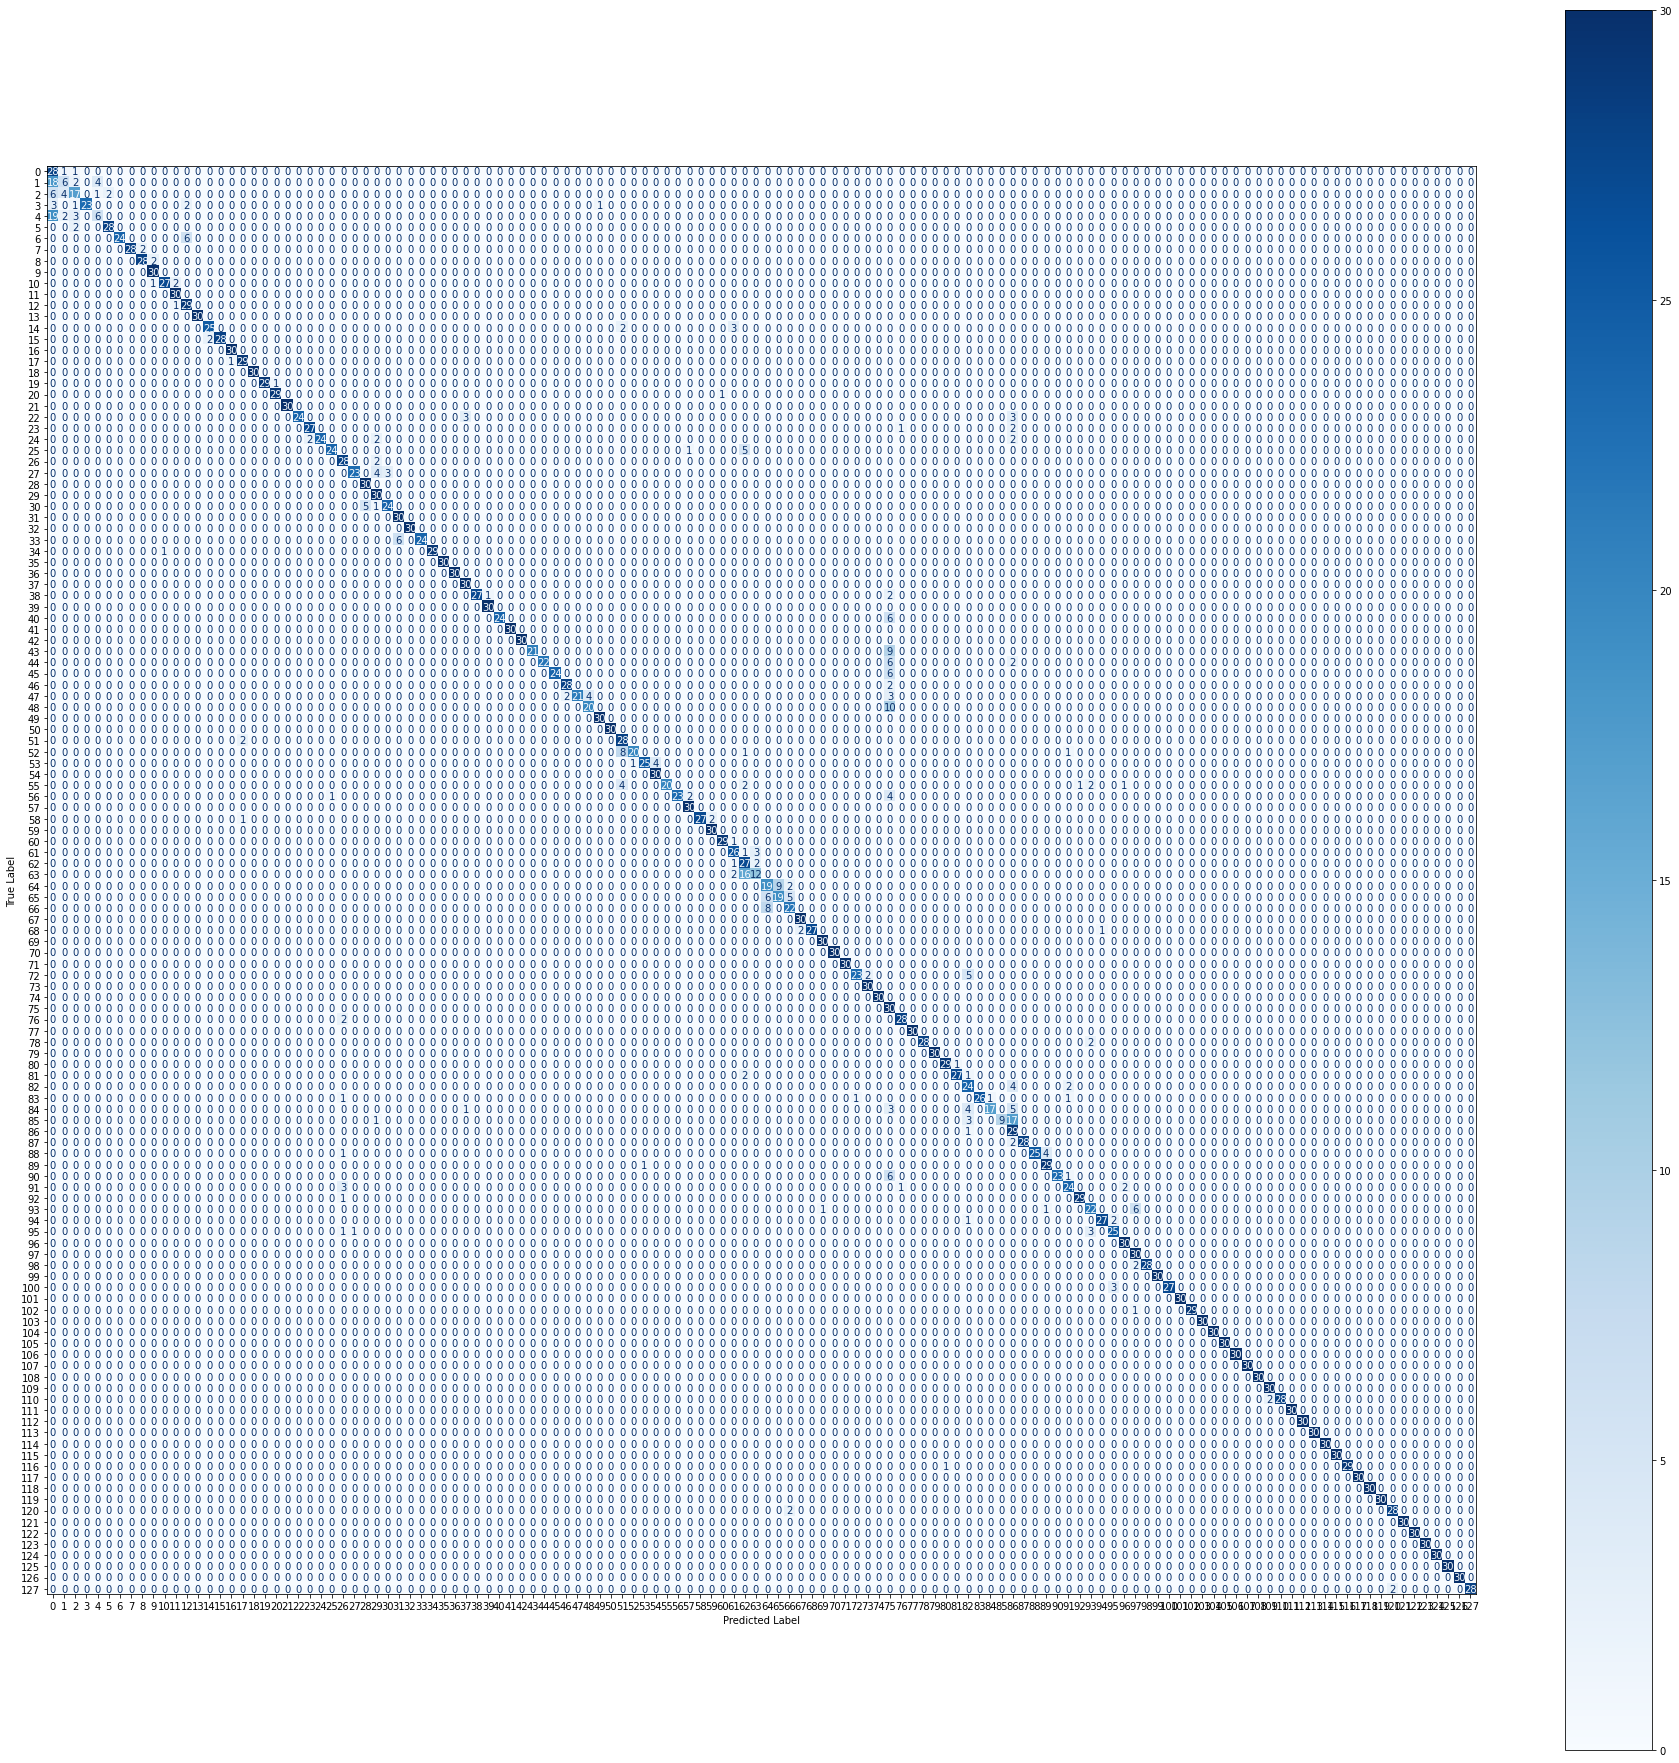

In [34]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
# 오차행렬
cm = confusion_matrix(y_test, y_pred_index)

plt.figure(figsize=(32,32))
ax = plt.gca()
disp = confusion_matrix(y_test, y_pred_index)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [35]:
with open(path + '/classify_ins_model.pickle', 'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://af699c5c-9a59-47ce-8fcd-0b02b4482f82/assets


In [36]:
# 불러오기
# with open(path + '/classify_ins_model.pickle', 'rb') as f:
#     mmodel = pickle.load(f)

In [37]:
# result = mmodel.evaluate(X_test, y_test, batch_size=64)
# print('test loss, test acc:', result)